# Klassificering av ickelinjär 2D-data

## Dataset
* genererat hittepå-dataset med lite brus
* 2 features - x och y
* 2 klasser (labels) - 0 och 1

## Modell
#### Modellen som ska byggas är ett neuralt nätverk med tre lager: två input-neuroner, tre "hidden" neuroner, en output-neuron.


<img src="ann.png" style="width: 500px;"/>

## Verktyg - samtliga är open source
* [scikit-learn](http://scikit-learn.org/stable/): verktygslåda för data-analys och maskininlärning 
* [Tensorflow](https://www.tensorflow.org): bibliotek för effektiva beräkningar, innehåller verktyg för att underlätta maskininlärning, finns även implementationer i js och lite-variant till android och ios
* [Keras](https://keras.io/): användarvänligt sätt att bygga neruala nätverk i python, måste användas ihop med backend för själva beräkningarna (tex TensorFlow)
* [matplotlib](https://matplotlib.org/): plotting-bibliotek
* [pandas](https://pandas.pydata.org/): diverse datastrukturer och operationer på dessa som är användbara vid data-analys
* [numpy](http://www.numpy.org/): mest för matriser och matrisoperationer, vilket behövs bla. för att få data i rätt format för modellen

In [109]:
import sklearn as sklearn
from sklearn import preprocessing, model_selection
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import math as math

## Läs in datasetet som pandas dataframes

In [262]:
with open('datasets/nonlinear_circle_data_with_noise.csv') as f:
    dataframe = pd.read_csv(f)
    
class_zero = dataframe[dataframe['label'] == 0]
class_one = dataframe[dataframe['label'] == 1]
dataframe.head()

,x,y,label
0,0.062005,-0.062031,1
1,0.114877,-0.387232,1
2,0.469452,1.146217,0
3,0.677714,-0.724361,0
4,0.959312,0.438573,0


## Plotta datasetet

<Figure size 1080x720 with 0 Axes>

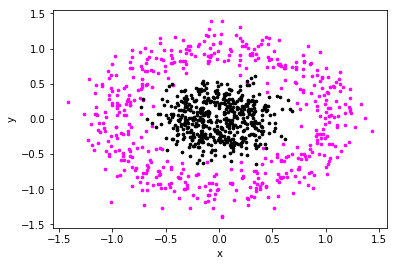

In [111]:
fig = plt.figure(figsize=(15,10))
ax = class_zero.plot.scatter('x','y', s=7, c='fuchsia')
class_one.plot.scatter('x','y', s=7, c='black', ax=ax)

## Lite processering av datasetet
### Skala om datan till intervallet [-1, 1]

In [36]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaled_df = dataframe.copy()
scaled_df[['x', 'y']] = scaler.fit_transform(dataframe[['x', 'y']])

### Splitta data i träningsset och testset

In [118]:
train_set_df, test_set_df, train_labels_df, test_labels_df = model_selection.train_test_split(
    scaled_df[['x','y']],
    scaled_df['label'], 
    test_size=0.2)
#om vi skulle vilja använda valideringsset:
#test_set_df, val_set_df, test_labels_df, val_labels_df = model_selection.train_test_split(
#    test_set_df[['x','y']],
#    test_labels_df, 
#    test_size=0.3)

### Konvertera dataframes till numpy-arrayer (matriser) och transponera (rader till kolumner)

In [119]:
train_set = np.array(train_set_df)
train_labels = np.array(train_labels_df)
test_set = np.array(test_set_df)
test_labels = np.array(test_labels_df)

#om vi skulle vilja använda valideringsset:
#val_set = np.array(val_set_df)
#val_labels = np.array(val_labels_df)

## Das model - det neurala nätverket
#### 3 lager: 2 input-neuroner, 3 "hidden" neuroner, 1 output-neuron


<img src="ann.png" style="width: 500px;"/>

### Definiera modellen med Keras och TensorFlow

In [254]:
#valet av activation bestämmer hur utsignalen från en neuron ska räknas ut
inputs = tf.keras.Input(shape=(2,))
x = tf.keras.layers.Dense(3, activation=tf.nn.sigmoid)(inputs)
outputs = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)

In [255]:
#optimizer: regel för hur uppdateringen av vikter och biases ska gå till (lärandet)
#lr (learning rate): i vilken grad vikter och biases ska uppdateras efter beräkning av fel 
#decay: (learning rate decay): hur mycket lr ska minska efter varje uppdatering, 
#       ju längre vi tränar, desto lägre blir lr, => ju mer data modellen sett, desto mindre
#       lättvindigt uppdaterar den sig
#loss (loss function, error function): hur felet/avståndet till rätt svar räknas ut
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.1, decay=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

### Träna modellen

In [256]:
#epochs: en epoch är när vi matat modellen med hela testsetet en gång
#batch_size: antalet datapunkter modellen får se innan felet räknas ut och uppdateringen sker 
history = model.fit(
    train_set, 
    train_labels, 
    epochs=500, 
    batch_size=32,
    verbose=0
)

### Vi plottar lite för att se vad som sker under träningen

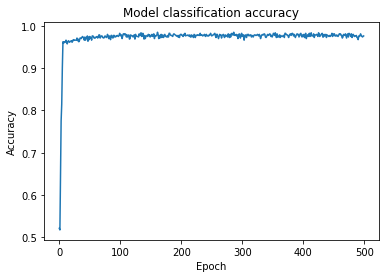

In [257]:
plt.plot(history.history['acc'])
plt.title('Model classification accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

### Klassificera data modellen inte tidigare sett (dvs testa den)

In [258]:
predictions = model.predict(test_set)
test_set_df['predicted'] = np.round(predictions).reshape(test_labels.shape)
test_set_df['label'] = test_labels
test_set_pred_zero = test_set_df[test_set_df['predicted'] == 0]
test_set_pred_one = test_set_df[test_set_df['predicted'] == 1]

### Accuracy för testdatan:

In [259]:
model.evaluate(test_set, test_labels, verbose=0)[1]

0.995

### Räkna ut decision boundary för modellen

In [260]:
plot_step = 0.02
x_min = -1.1
x_max = 1.1
y_min = -1.1
y_max = 1.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))
meshgrid_data = np.column_stack((xx.ravel(), yy.ravel()))
decision_boundary = model.predict(meshgrid_data)
decision_boundary = decision_boundary.reshape(xx.shape)

### Plotta modellens decision boundary och hur den klassificerat data

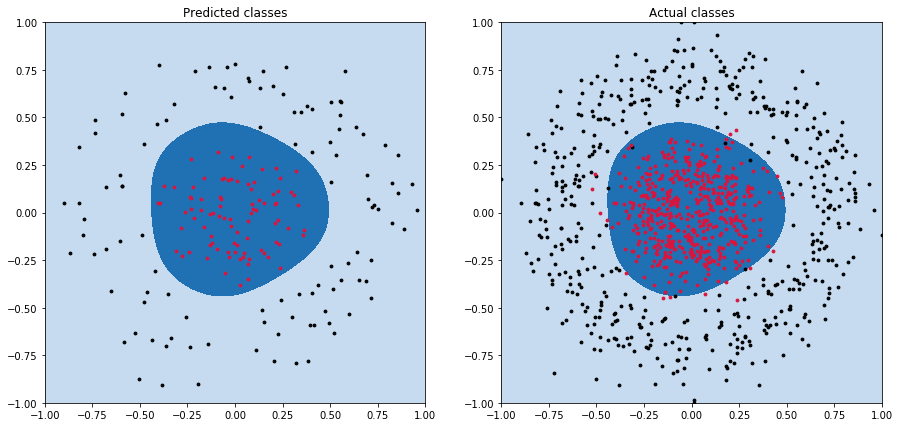

In [261]:
fig2, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
ax1.contourf(xx, yy, decision_boundary, levels=[0,0.5,1], cmap=plt.cm.Blues)
ax2.contourf(xx, yy, decision_boundary, levels=[0,0.5,1], cmap=plt.cm.Blues)
ax1.scatter(test_set_pred_zero['x'], test_set_pred_zero['y'], s=8, c='black')
ax1.scatter(test_set_pred_one['x'], test_set_pred_one['y'], s=8, c='crimson')
scaled_class_zero = scaled_df[scaled_df['label'] == 0]
scaled_class_one = scaled_df[scaled_df['label'] == 1]
ax2.scatter(scaled_class_zero['x'], scaled_class_zero['y'], s=8, c='black')
ax2.scatter(scaled_class_one['x'], scaled_class_one['y'], s=8, c='crimson')
ax1.set_title('Predicted classes')
ax2.set_title('Actual classes')
ax2.set_xbound(-1,1)
ax2.set_ybound(-1,1)
ax1.set_xbound(-1,1)
ax1.set_ybound(-1,1)
